In [1]:
import numpy as np 
from scipy.stats import zipf
import matplotlib.pyplot as plt
from numba import jit
from tqdm.auto import trange
import torch
from seaborn import kdeplot 

plt.style.use('fast')

In [18]:
n_agents = 20
n_generations = 100
n_encounters = 5000
n_meanings = 50
selection = 0.01
mutation_rate = 0.2
    

In [19]:
# generate a freq distribution of meanings using zipf
freq_meanings = zipf.rvs(1.5, size=n_meanings)
# freq_meanings = np.ones(n_meanings)
freq_meanings = freq_meanings / np.sum(freq_meanings)

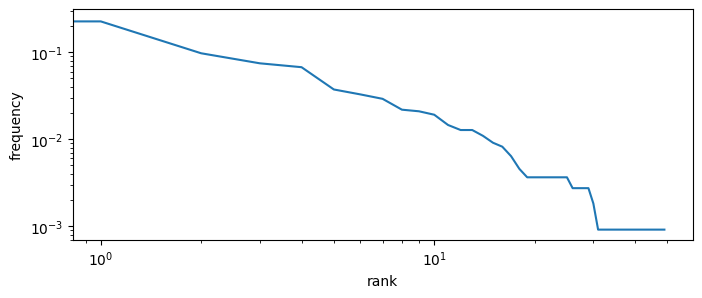

In [20]:
# plot freq_meanings as a rank frequency plot
plt.figure(figsize=(8, 3))
plt.plot(np.arange(n_meanings), sorted(freq_meanings)[::-1])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.loglog()
plt.show()

In [21]:
word_meaning_matrix = np.zeros((n_agents, n_meanings))
# fill every value with np.round(np.random.lognormal(1, 0.4)) as value
for i in range(n_agents):
    word_meaning_matrix[i, :] = np.round(np.random.lognormal(1, 0.5, n_meanings))

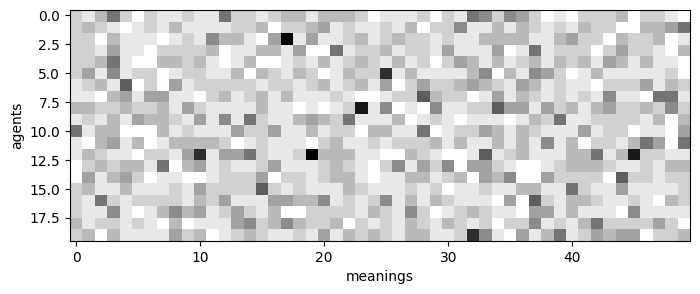

In [23]:
plt.figure(figsize=(8, 3))
plt.imshow(word_meaning_matrix, aspect='auto', cmap='gray_r')
# plt.clim(0, 10)
plt.xlabel('meanings')
plt.ylabel('agents')
plt.show()

In [91]:
# @torch.compile
def model(selection, mutation_rate, zipf = 1.5, detailed = False):
    n_generations = 50
    n_encounters = 5000
    n_meanings = 5000
    n_agents = 5000

    corr_coeffs = []

    freq_meanings = np.random.zipf(zipf, size=n_meanings)
    freq_meanings = freq_meanings / np.sum(freq_meanings)
    word_meaning_matrix = np.round(np.random.lognormal(1, 0.6, (n_agents, n_meanings)))

    for _ in range(n_generations):
        for _ in range(n_encounters):
            agent1, agent2 = np.random.choice(n_agents, 2, replace=False)
            meaning = np.random.choice(n_meanings, p=freq_meanings)
            wordform1, wordform2 = word_meaning_matrix[agent1, meaning], word_meaning_matrix[agent2, meaning]

            if np.random.rand() <= selection:
                word_meaning_matrix[agent2, meaning] = np.minimum(wordform1, wordform2)
                word_meaning_matrix[agent1, meaning] = np.minimum(wordform1, wordform2)
            else:
                if np.random.rand() < 0.5:
                    word_meaning_matrix[agent1, meaning] = wordform2
                else:
                    word_meaning_matrix[agent2, meaning] = wordform1

        mutation_agents = np.random.rand(n_agents) < mutation_rate
        mutated_agents = np.where(mutation_agents)[0]
        word_meaning_matrix[mutated_agents, :] = np.round(np.random.lognormal(0, 0.6, 
                                                                            (len(mutated_agents), 
                                                                                n_meanings)))
        corr_coeffs.append(np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1])
    if detailed:
        return corr_coeffs, word_meaning_matrix
    else:
        return np.corrcoef(freq_meanings, np.mean(word_meaning_matrix, axis=0))[0, 1]


In [92]:
# # plot the correlation between meaning frequencies and average word lengths as a funciton of zipf
# zipfs = np.linspace(1.2, 2.5, 20)
# corrs = []
# for zipf in zipfs:
#     corrs.append(model(selection = 0.5, mutation_rate = 0.2, zipf = zipf))

In [93]:
# plt.figure(figsize=(8, 3))
# plt.plot(zipfs, corrs)
# plt.xlabel('Zipf distribution parameter')
# plt.ylabel('ZLA strength')
# plt.show()

In [112]:
out, wm_m = model(1, 0.3, detailed=True)

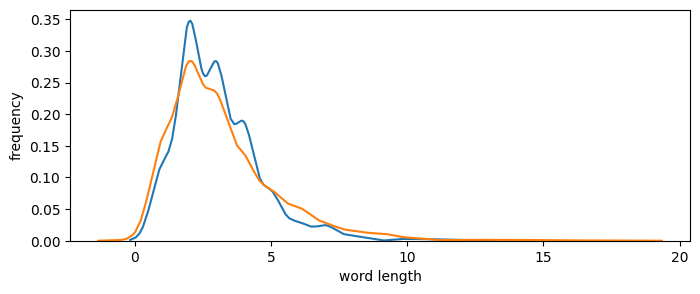

In [113]:
# plot distribution of word lengths
plt.figure(figsize=(8, 3))
# plot the initial distribution of word lengths using seaborn and distplot
kdeplot(word_meaning_matrix.flatten(), label = 'model lengths')
kdeplot(np.round(np.random.lognormal(1, 0.6, 2000)), label = 'initial lengths')
plt.xlabel('word length')
plt.ylabel('frequency')
plt.legend()
plt.show()

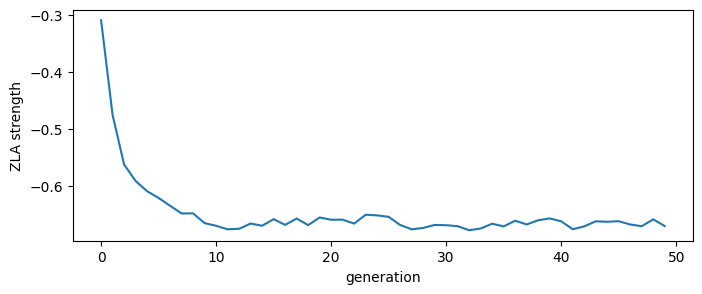

In [114]:
# plot out
plt.figure(figsize=(8, 3))
plt.plot(out)
plt.xlabel('generation')
plt.ylabel('ZLA strength')
plt.show()

In [57]:
selections = np.linspace(0.01, 1, 11)
mutation_rates = np.linspace(0.01, 1, 11)

results = np.zeros((len(selections), len(mutation_rates)))

# use tqdm
for i in trange(len(selections)):
    for j in range(len(mutation_rates)):
        results[i, j] = model(selections[i], mutation_rates[j])
        # results[i, j] = np.mean([model(selections[i], mutation_rates[j]) for _ in range(1)])

  0%|          | 0/11 [00:00<?, ?it/s]

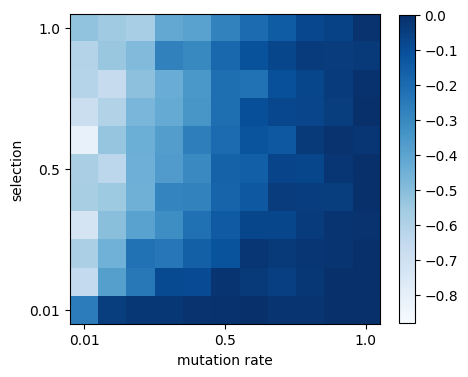

In [60]:
# plot the results as a heatmap
plt.figure(figsize=(5, 5))
plt.imshow(results, cmap='Blues')
plt.xlabel('mutation rate')
plt.ylabel('selection')
# add xticks and yticks but display every 5th value
plt.xticks(np.arange(len(mutation_rates))[::5], np.round(mutation_rates[::5], 2))
plt.yticks(np.arange(len(selections))[::5], np.round(selections[::5], 2))
# reverse y axis ticks
plt.gca().invert_yaxis()
# small colorbar
plt.colorbar(shrink=0.8)
plt.clim(0, -0.8)
plt.show()

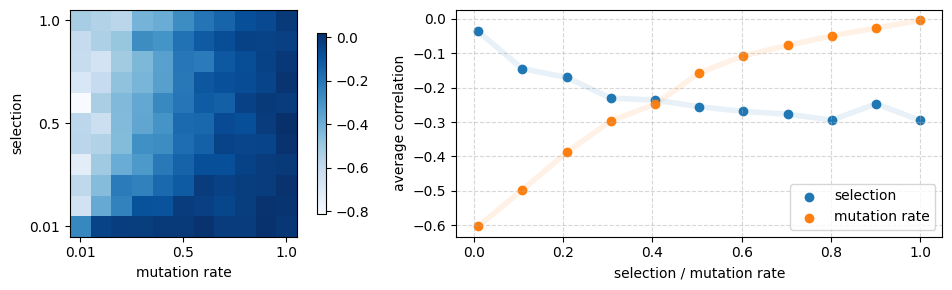

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 1.2]})

# heatmap
im = ax1.imshow(results, cmap='Blues')
ax1.set_xlabel('mutation rate')
ax1.set_ylabel('selection')

# add xticks and yticks but display every 5th value
ax1.set_xticks(np.arange(len(mutation_rates))[::5])
ax1.set_xticklabels(np.round(mutation_rates[::5], 2))
ax1.set_yticks(np.arange(len(selections))[::5])
ax1.set_yticklabels(np.round(selections[::5], 2))
# reverse y axis ticks
ax1.invert_yaxis()
# Add colorbar
fig.colorbar(im, ax=ax1, shrink=0.8)

# scatter
ax2.scatter(selections, np.mean(results, axis=1), label='selection')
ax2.plot(selections, np.mean(results, axis=1), alpha=0.1, linewidth=4)
ax2.scatter(mutation_rates, np.mean(results, axis=0), label='mutation rate')
ax2.plot(mutation_rates, np.mean(results, axis=0), alpha=0.1, linewidth=4)
ax2.set_xlabel('selection / mutation rate')
ax2.set_ylabel('average correlation')
ax2.legend()
ax2.grid(alpha=0.5, linestyle='--')

# Adjust vertical alignment
fig.subplots_adjust(bottom=0.2, top=0.8)

# Adjust horizontal alignment
fig.subplots_adjust(wspace=0.1)

plt.tight_layout()
plt.show()
